# Exploring Police Logs

## Requirements
1. Read logs from postgres database
1. Split logs based on types
1. Plot some types to visualize the data

The block below connects to a local postgres db, and queries all the row in the police_log table.

In [124]:
import psycopg2
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
conn = psycopg2.connect(dbname="postgres", user="postgres")
conn.autocommit = True
cursor = conn.cursor()
cursor.execute("SELECT * FROM police_log")
rows = cursor.fetchall()
conn.close()

This code block generates a basic map of Framingham, used in some of the type further down below.

In [56]:
def generateBaseMap(default_location=[42.2804896, -71.4176461], default_zoom_start=12):
    base_map = folium.Map(
        location=default_location, 
        control_scale=True, 
        zoom_start=default_zoom_start
    )
    return base_map

Turns the raw postgres rows into a sensible dataframe.

In [57]:
logs = pd.DataFrame(
    rows, 
    columns = ['Id', 'Time', 'Type', 'Note', 'Address', 'date', 'load_date', 'lat_long']
)

logs.set_index('Id')
logs = logs.sort_values(['date','Time'], ascending=True)

Below is a basic chart to understand the most frequent types of police logs.

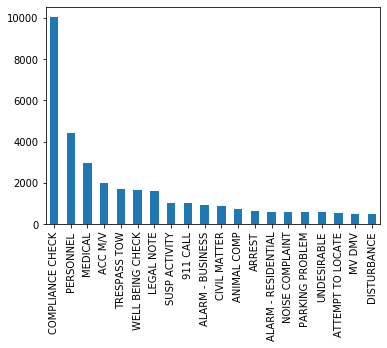

In [60]:
logs['Type'].value_counts().head(20).plot.bar()

Code block below filters out some of the more administrative types of police logs

In [61]:
types = logs['Type'].unique()

exclude = ['COMPLIANCE CHECK','ALARM - RESIDENTIAL','PERSONNEL', 
           'ALARM - BUSINESS', 'POLICE INFO', 'PRISONERS COURT', 
           'WARRANT SERVICE', 'RELEASED','FIRE ALARM', 'SCHOOL POST', 
           'DUPLICATE ENTRY', 'TEST', 'NSTAR NOTIFICATION']

logs_final = logs[~logs['Type'].isin(exclude)]

What are the most frequent types of logs?

Text(0.5, 0, 'Log Type')

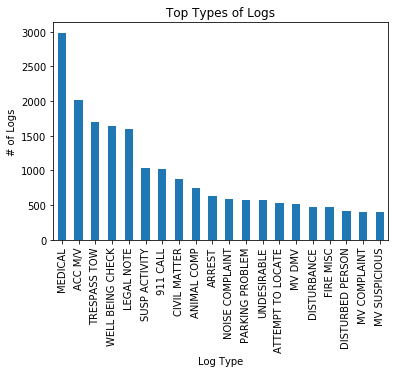

In [100]:
logs_final['Type'].value_counts().head(20).plot.bar()
plt.title('Top Types of Logs')
plt.ylabel('# of Logs')
plt.xlabel('Log Type')

Splits types based on 'serious' and motor vehicle logs, subjective based on my judgement

In [64]:
mv_types = []
suspicious_types = []
serious_types = ['FIREARM', 'LARCENY', 'DISTURBED PERSON', 'ACC HIT/RUN', 
                 'FIGHT', 'ACC CRIMINAL', 'MAL/DEST/PROP','PROPERTY LOST/STOLEN', 
                 'BREAKING ENTERING','ASSAULT', 'SHOPLIFTER', 'LARCENY - SCAM',
                 'BIKE LARCENY', 'ATTEMPTED BREAK', 'UNARMED ROBBERY', 'BOMB THREAT',
                 'LARCENY - PRESCRIPTION', 'ARMED ROBBERY', 'ATTEMPTED CRIME',
                 'TELEPHONE FRAUD', 'IDENTITY FRAUD', 'GUNSHOTS', 'HOUSE INVASION'
                ]

for type in logs_final['Type'].unique():
    if 'mv' in type.lower() or 'acc' in type.lower() or 'm/v' in type.lower() or 'traffic' in type.lower() or 'signal' in type.lower():
        mv_types.append(type)
    if 'susp' in type.lower():
        suspicious_types.append(type)

What are the most frequent 'serious' log types?

Text(0.5, 0, 'Log Type')

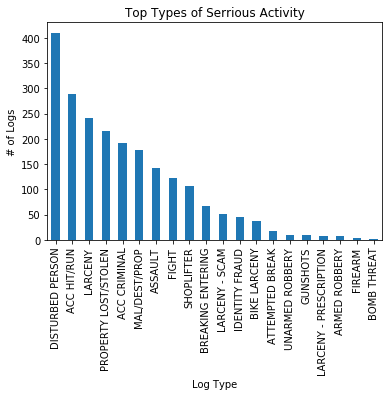

In [99]:
serious_logs = logs_final[logs_final['Type'].isin(serious_types)]
serious_logs['Type'].value_counts().head(20).plot.bar()
plt.title('Top Types of Serious Activity')
plt.ylabel('# of Logs')
plt.xlabel('Log Type')

What're the most frequent types of suspicious activity?

Text(0.5, 0, 'Log Type')

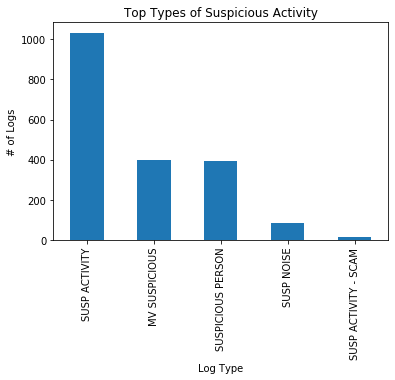

In [98]:
suspicious_logs = logs_final[logs_final['Type'].isin(suspicious_types)]
suspicious_logs['Type'].value_counts().head(20).plot.bar()
plt.title('Top Types of Suspicious Activity')
plt.ylabel('# of Logs')
plt.xlabel('Log Type')

What're the most frequent types of motor vehicle logs?

Text(0.5, 0, 'Log Type')

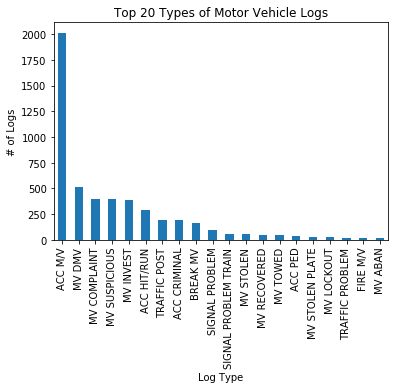

In [97]:
mv_logs = logs_final[logs_final['Type'].isin(mv_types)]
mv_logs['Type'].value_counts().head(20).plot.bar()
plt.title('Top 20 Types of Motor Vehicle Logs')
plt.ylabel('# of Logs')
plt.xlabel('Log Type')

Where do most accidents occur?

In [153]:
mv_accidents = logs_final[logs_final['Type'] == 'ACC M/V']
accident_map = generateBaseMap()

def lat(string):
    lat_lon = string.split(',')
    try:
        lat = float(lat_lon[0][1:])
        return lat
    except:
        return np.nan
    

def lon(string):
    lat_lon = string.split(',')
    try:
        lon = float(lat_lon[1][:-1])
        return lon
    except:
        return np.nan

    
mv_accidents['lat'] = mv_accidents['lat_long'].apply(lat)
mv_accidents['lon'] = mv_accidents['lat_long'].apply(lon)

mv_accidents = mv_accidents[~mv_accidents['lat'].isna()]
mv_accidents = mv_accidents[~mv_accidents['lon'].isna()]


accident_map.add_children(plugins.HeatMap(zip(mv_accidents['lat'], mv_accidents['lon']), radius = 7))


/Users/williamgetman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/williamgetman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/williamgetman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


Where are fireworks fired of most frequently?

In [82]:
fireworks = logs_final[logs_final['Type'] == 'FIREWORKS']
firework_map = generateBaseMap()

for id, row in fireworks.iterrows():
    lat_lon = row['lat_long'].split(',')
    lat = lat_lon[0][1:]
    lon = lat_lon[1][:-1]
    #print(row['date'],row['Time'], row['Note'], row['Address'])
    if 'unfounded' not in row['Note'].lower():
        folium.Marker(
            location=[lat, lon],
            popup = '{} {}: {}: {}'.format(row['date'],row['Time'],row['Address'], row['Note'])
        ).add_to(firework_map)
    
firework_map